This notebook is used to test out various LSTM models where the test set is comprised of a week held out each month.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import itertools
import datetime as dt
from datetime import timedelta
import pydot
#import pydotplus
import graphviz

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

%matplotlib inline
plt.style.use("seaborn")

## Read in data 

In [2]:
# Read in CSV from github repository
connecticut = pd.read_csv("data/connecticutData.csv")

In [3]:
# Selecting variables of interest
connecticut = connecticut[['DateTimeObj','LocalDt','Date','LoadMW','LoadMW_Plus1','OnPeak','cos_HourE','sin_HourE','TempF','Humidity']]

As a reminder, my final list of potential features is thus: LoadMW, OnPeak, sin_HourE, cos_HourE, TempF, and Humidity. I will try out various combinations of said variables in my network.

# Create train/test split

Due to how I need to stack the observations for the LSTM network input, I need to do some manipulation to get the correct columns for our test set. I take the indices for the observations in my test set and subtract 8 from them so that we are getting the 8 previous observations for our stacks. Note that if you change n_steps, say to 3, then you would be subtracting 2.

For simplicity I create a global variable "steps_minus1" to easily switch between models of different step size.

In [4]:
steps_minus1 = 8

In [5]:
# First let's create the set of days I want to hold out
# This will be 12 weeks, one from each month, and in the months we have the most current data for

test_dates = ['2020-11-08','2020-11-09','2020-11-10','2020-11-11','2020-11-12','2020-11-13','2020-11-14','2020-12-20','2020-12-21','2020-12-22','2020-12-23','2020-12-24','2020-12-25','2020-12-26','2021-01-24','2021-01-25','2021-01-26','2021-01-27','2021-01-28','2021-01-29','2021-01-30','2021-02-14','2021-02-15','2021-02-16','2021-02-17','2021-02-18','2021-02-19','2021-02-20','2021-03-07','2021-03-08','2021-03-09','2021-03-10','2021-03-11','2021-03-12','2021-03-13','2021-04-11','2021-04-12','2021-04-13','2021-04-14','2021-04-15','2021-04-16','2021-04-17','2021-05-23','2021-05-24','2021-05-25','2021-05-26','2021-05-27','2021-05-28','2021-05-29','2021-06-13','2021-06-14','2021-06-15','2021-06-16','2021-06-17','2021-06-18','2021-06-19','2021-07-18','2021-07-19','2021-07-20','2021-07-21','2021-07-22','2021-07-23','2021-07-24','2021-08-15','2021-08-16','2021-08-17','2021-08-18','2021-08-19','2021-08-20','2021-08-21','2021-09-05','2021-09-06','2021-09-07','2021-09-08','2021-09-09','2021-09-10','2021-09-11','2021-10-24','2021-10-25','2021-10-26','2021-10-27','2021-10-28','2021-10-29','2021-10-30']
test_df = connecticut[connecticut['Date'].isin(test_dates)]

# Get indices associated with these observations
test_indices = list(test_df.index)

# Correct for the lag due to our stacking of time obvs
test_i = [x - steps_minus1 for x in test_indices]

# Get training indices
train_i = [x for x in list(connecticut.index) if x not in test_i]

# Correct for the lag due to our stacking of time obvs
train_i = train_i[: len(train_i) - steps_minus1]

## Scale variables

In [6]:
# Initialize dataframe for scaled values
con_scaled = connecticut.copy()

# Initialize scaler (here we use Min/Max)
sc = MinMaxScaler()

# Choose which quantitative and quantitative features to use
qual_vars = ["TempF",'Humidity',"LoadMW"]

# Note that the cyclical/one-hot-encoded variables are already scaled, let's define these separately
#quan_vars = ['OnPeak','cos_HourE','sin_HourE']
quan_vars = ['OnPeak','cos_HourE','sin_HourE']

# Fit
sc_x = StandardScaler().fit(con_scaled[qual_vars])
sc_y = StandardScaler().fit(con_scaled["LoadMW_Plus1"].values.reshape(-1,1))

# Scale quantitative variables
con_scaled[qual_vars] = sc_x.transform(con_scaled[qual_vars])
con_scaled["LoadMW_Plus1"] = sc_y.transform(con_scaled["LoadMW_Plus1"].values.reshape(-1,1))

In [7]:
# Remove time objects from scaled dataframe
con_scaled = con_scaled[list(itertools.chain(qual_vars, quan_vars, ['LoadMW_Plus1']))]
con_scaled.head()

,TempF,Humidity,LoadMW,OnPeak,cos_HourE,sin_HourE,LoadMW_Plus1
0,-1.044535,0.486836,-1.013228,0,0.965926,0.258819,-1.115085
1,-1.212882,0.637613,-1.115090,0,0.866025,0.500000,-1.146342
2,-1.321494,1.190465,-1.146347,0,0.707107,0.707107,-1.122062
3,-1.261757,1.140205,-1.122067,0,0.500000,0.866025,-0.990617
4,-1.212882,0.838650,-0.990623,0,0.258819,0.965926,-0.620562


## Reshape data and split

I reshape these timeseries into multiple samples where each sample has n_steps time units for each input series, and one output corresponding to load at the next time. This process is taken from a blog post by machinelearningmastery. It requires I:

(1) Turn my features/target into arrays and horizontally stack them

(2) Run them through a split_sequences() function to generate samples of (n_steps, n_features) matrices with a corresponding (target) output.

In [8]:
# Put our timeseries variables into arrays and horizontally stack them
# This input format is necessary to be able to run through the split_sequences() function
in_seq1 = np.array(con_scaled["LoadMW"])
in_seq2 = np.array(con_scaled["TempF"])
in_seq3 = np.array(con_scaled["cos_HourE"])
in_seq4 = np.array(con_scaled["sin_HourE"])
in_seq5 = np.array(con_scaled["Humidity"])
in_seq6 = np.array(con_scaled["OnPeak"])
out_seq = np.array(con_scaled["LoadMW_Plus1"])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1)) 
in_seq4 = in_seq4.reshape((len(in_seq4), 1)) 
in_seq5 = in_seq5.reshape((len(in_seq5), 1)) 
in_seq6 = in_seq6.reshape((len(in_seq6), 1)) 
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, out_seq))

# The function below splits our dataset into samples of sequences of time stpes
# It is taken from machinelearningmastery
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# Here n = the number of time steps in each sample
# NOTE: if changed, you MUST have the amount we subtract from the indices to find the train/test sample locations
n_steps = steps_minus1 + 1
X, y = split_sequences(dataset, n_steps)

# Split into training/test sets
x_train = X[train_i]
x_test = X[test_i]
y_train = y[train_i]
y_test = y[test_i]

In [9]:
# Doing a sanity check to make sure the train/test samples are of the correct shape
print(X.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(26199, 9, 6) (26199,)
(24351, 9, 6) (24351,)
(1848, 9, 6) (1848,)


In [10]:
# Taking a look at one input/output sample
print("Input:")
print(*np.round(x_train[1],10), sep='\n')
print("\nOutput:")
print(np.round(y_train[1],4))

Input:
[-1.11509049 -1.21288224  0.8660254   0.5         0.6376133   0.        ]
[-1.14634693 -1.32149365  0.70710678  0.70710678  1.19046465  0.        ]
[-1.12206738 -1.26175738  0.5         0.8660254   1.14020544  0.        ]
[-0.99062288 -1.21288224  0.25881905  0.96592583  0.83865016  0.        ]
[-0.62056895 -1.15314596  0.          1.          0.9894278   0.        ]
[ 0.02772313 -1.09340968 -0.25881905  0.96592583  0.93916858  0.        ]
[ 0.38800942 -0.93592313 -0.5         0.8660254   0.68787252  1.        ]
[ 0.4160565  -0.66439459 -0.70710678  0.70710678 -0.01575647  1.        ]
[ 0.35159009 -0.60465832 -0.8660254   0.5        -0.1665341   1.        ]

Output:
0.3198


## Create LSTM Model

In [11]:
# Create architecture

n_features = x_train.shape[2]

# Define layers & add to model
layer1 = LSTM(100, input_shape=(n_steps, n_features), activation='relu', return_sequences=True)
layer2 = LSTM(100,activation='relu')
output = Dense(1)
layers_lstm = [layer1,layer2,output]

model = Sequential()
for layer in layers_lstm:
  model.add(layer)

# Define hyperparameters
loss = 'mse'
op = 'adam'
metrics = ['mse','mae']
size = 32
n_epochs = 50

model.compile(loss=loss, optimizer=op, metrics=metrics)
history_lstm = model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            batch_size=size, epochs=n_epochs, verbose = 1)  

2022-04-27 18:49:04.010095: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-27 18:49:04.440887: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
761/761 [==============================] - 16s 18ms/step - loss: 0.0481 - mse: 0.0481 - mae: 0.1358 - val_loss: 0.0060 - val_mse: 0.0060 - val_mae: 0.0588
Epoch 2/50
761/761 [==============================] - 15s 19ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0592 - val_loss: 0.0062 - val_mse: 0.0062 - val_mae: 0.0625
Epoch 3/50
761/761 [==============================] - 15s 20ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0515 - val_loss: 0.0046 - val_mse: 0.0046 - val_mae: 0.0510
Epoch 4/50
761/761 [==============================] - 18s 23ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0476 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0445
Epoch 5/50
761/761 [==============================] - 23s 30ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0459 - val_loss: 0.0071 - val_mse: 0.0071 - val_mae: 0.0679
Epoch 6/50
761/761 [==============================] - 20s 26ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0453 - val_loss: 0.0024 - val_mse: 0.0024 - val_mae: 0.0366
Epoc

761/761 [==============================] - 14s 18ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0301 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0312


In [12]:
# Save model for deployment
#model.save("loadFcastLSTM.h5")

Plotting the training/test set loss vs. epoch to check for convergence. 

Training loss on the final epoch was: 0.0018
58/58 [==============================] - 0s 6ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0312
MSE on unscaled data is: 911.2940440172536
MAE on unscaled data is: 22.34298874363754


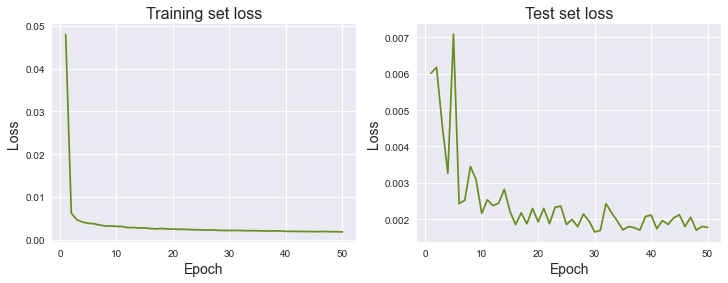

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, n_epochs+1), history_lstm.history['loss'], color = 'olivedrab')
plt.title('Training set loss', fontdict = {'fontsize' : 16})
plt.xlabel('Epoch', fontdict = {'fontsize' : 14})
plt.ylabel('Loss', fontdict = {'fontsize' : 14})

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, n_epochs+1), history_lstm.history['val_loss'], color='olivedrab')
plt.title('Test set loss', fontdict = {'fontsize' : 16})
plt.xlabel('Epoch', fontdict = {'fontsize' : 14})
plt.ylabel('Loss', fontdict = {'fontsize' : 14})
#plt.savefig('figures/epoch_loss.eps', format='eps')

print(f"Training loss on the final epoch was: {history_lstm.history['loss'][-1]:0.4f}")

# Here we can evaluate how our model does based on the test data
model.evaluate(x_test, y_test)

# Looking at the predictions
yhat = model.predict(x_test, verbose=0)
predictions = sc_y.inverse_transform(yhat)
y_test_unsc = sc_y.inverse_transform(y_test.reshape(-1,1))

print(f"MSE on unscaled data is: {mean_squared_error(y_test_unsc,predictions)}")
print(f"MAE on unscaled data is: {mean_absolute_error(y_test_unsc,predictions)}")

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 100)            42800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 123,301
Trainable params: 123,301
Non-trainable params: 0
_________________________________________________________________


Creating a diagram of the model for presentation purposes.

In [15]:
#tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

## Creating actual vs. forecast plots for selected test set days

In [16]:
# Intialize 
pred_df = connecticut[["Date","LocalDt","LoadMW_Plus1"]].iloc[test_i] # Get dates with same indices as in our test dataset
pred_df["y_hat"] = predictions
pred_df.head()

,Date,LocalDt,LoadMW_Plus1,y_hat
17897,2020-11-07,11/7/2020 16:00,3100.8,2032.116577
17898,2020-11-07,11/7/2020 17:00,3035.1,1982.110474
17899,2020-11-07,11/7/2020 18:00,2909.5,1975.041626
17900,2020-11-07,11/7/2020 19:00,2750.9,2011.640625
17901,2020-11-07,11/7/2020 20:00,2609.2,2067.557861


/var/folders/tc/ky0xv15j47z6fxhf6cykcv040000gn/T/ipykernel_16104/3577983721.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_data["RealTime"] = chart_data["LocalDt"].apply(


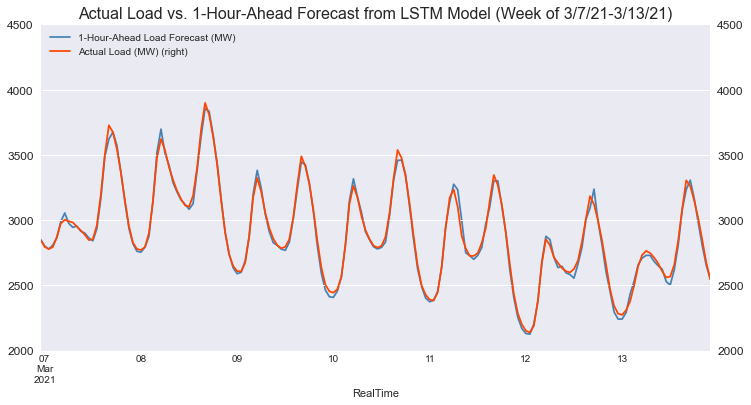

In [22]:
# Intialize 
pred_df = connecticut[["Date","LocalDt","LoadMW_Plus1"]].iloc[test_indices] # Get dates with same indices as in our test dataset
pred_df["y_hat"] = predictions

test_dates = ['2021-03-07','2021-03-08','2021-03-09','2021-03-10','2021-03-11','2021-03-12','2021-03-13']
firstweek = pred_df[pred_df["Date"].isin(test_dates)]
firstweek

chart_data = firstweek
chart_data.dtypes

chart_data["RealTime"] = chart_data["LocalDt"].apply(
    lambda x: dt.datetime.strptime(x, "%m/%d/%Y %H:%M") - timedelta(hours=1)
)
chart_data = chart_data.sort_values(["RealTime"], ascending=True)

chart_data = chart_data.set_index(pd.to_datetime(chart_data.RealTime), drop=True)


# Plot
#plt.style.use("default")

plt.figure(figsize=(12,6))
plt.xticks(fontsize=12)

ax1 = chart_data.y_hat.plot(color='steelblue', grid=False, label="1-Hour-Ahead Load Forecast (MW)")
ax1.set_ylim([2000, 4500])
plt.yticks(fontsize=12)
ax2 = chart_data.LoadMW_Plus1.plot(color='orangered', grid=False, secondary_y=True, label="Actual Load (MW)")
ax2.set_ylim([2000, 4500])
plt.yticks(fontsize=12)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.title('Actual Load vs. 1-Hour-Ahead Forecast from LSTM Model (Week of 3/7/21-3/13/21)', fontdict = {'fontsize' : 16})

plt.legend(h1+h2, l1+l2, loc=2)

#plt.show()
plt.savefig('figures/lstm_model_results.eps', format='eps')